In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

In [2]:
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")

Using cache found in /user/HS400/rl01179/.cache/torch/hub/facebookresearch_dinov2_main
/user/HS400/rl01179/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/user/HS400/rl01179/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/user/HS400/rl01179/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
transform = tv.transforms.Compose(
    [
        tv.transforms.ToTensor(),
        tv.transforms.Resize((256, 256)),
        tv.transforms.CenterCrop(224),
        tv.transforms.Normalize(
            mean=[0.4547, 0.4337, 0.4011], std=[0.2266, 0.2237, 0.2316]
        ),
    ]
)

dataset = tv.datasets.ImageFolder(root="./data/Places2_simp", transform=transform)
classes = dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airport_terminal


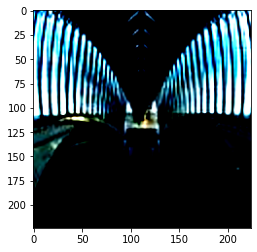

In [5]:
import matplotlib.pyplot as plt

img = dataset[1]
plt.imshow(img[0].permute(1, 2, 0))
print(classes[img[1]])

In [ ]:
from tqdm import tqdm

all_embs = []
all_labels = []


def embeddings(dataset):
    for i in tqdm(range(len(dataset))):
        with torch.no_grad():
            try:
                out = dinov2.cuda()(dataset[i][0][None].cuda())
            except:
                continue

        all_embs.append(out.cpu())
        all_labels.append(dataset[i][1])


embeddings(dataset)

100%|██████████| 40000/40000 [08:58<00:00, 74.32it/s]


In [7]:
p = torch.randperm(len(all_labels))
all_embs = torch.concat(all_embs)[p]
all_labels = torch.tensor(all_labels, dtype=torch.long)[p]

In [8]:
train_embs, val_embs = all_embs[:32000], all_embs[32000:]
train_labels, val_labels = all_labels[:32000], all_labels[32000:]

In [14]:
import pickle

In [9]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=40)
neigh.fit(train_embs, train_labels)

KNeighborsClassifier(n_neighbors=40)

In [15]:
with open("knn_pickle.pkl", "wb") as f:
    pickle.dump(neigh, f)

In [ ]:
top_1 = (neigh.predict(val_embs) == val_labels).sum() / 8000

tensor(0.7680)

In [34]:
probs = neigh.predict_proba(val_embs)
top_5 = (probs.argsort()[:, -5:] == val_labels[:, None]).sum() / 8000

In [ ]:
top_5

tensor(0.9556)

In [ ]:
from sklearn.svm import SVC

sv = SVC(kernel="rbf", probability=True)
sv.fit(train_embs, train_labels)

SVC(probability=True)

In [17]:
acc = (sv.predict(val_embs) == val_labels).sum() / 8000

In [18]:
acc

tensor(0.8058)

In [19]:
sv_out = sv.predict_proba(val_embs)

In [32]:
top_5 = (sv_out.argsort()[:, -5:] == val_labels[:, None]).sum() / 8000
print(top_5)

tensor(0.9789)


In [21]:
with open("svc.pkl", "wb") as f:
    pickle.dump(sv, f)

In [23]:
import cv2

In [37]:
with open("svc.pkl", "rb") as f:
    sv1 = pickle.load(f)

In [38]:
img = cv2.imread("notebooks/haha2.jpeg")[:, :, ::-1]
img = img.copy()
tensor = transform(img)

In [39]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


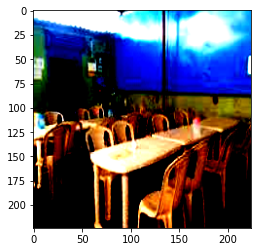

In [40]:
plt.imshow(tensor.permute(1, 2, 0))

In [41]:
with torch.no_grad():
    out = dinov2(tensor[None].to("cuda"))
out.shape

torch.Size([1, 768])

array([31])